What I've done so far

In [1]:
import geopandas as gpd
from glob import glob
import dask.dataframe as da
from dask.distributed import LocalCluster, Client
import matplotlib.pyplot as plt
import os
import rioxarray as rio
import xarray as xr
# from dem_utils import ArcticDEM
from tqdm import tqdm
import numpy as np
import pandas as pd
import numpy as np
from shapely import wkt
# import utils
import cartopy.crs as ccrs
import shapely
from rasterio.features import rasterize
from rasterio.enums import Resampling
import seaborn as sns
# import odc.geo.xr
from cycler import cycler
prj = ccrs.Stereographic(
    central_latitude=90,
    central_longitude=-45,
    true_scale_latitude=70
)


In [3]:
# helper functions
def demote_coords_to_vars(ds: xr.Dataset,
                        coords: str,
                        var_name: str):
    '''
    messy onliner to for reorganizing dataset.
    e.g. dataset with two variables: a (dims: x, y, t) and b (dims: x, y)
    this function will convert it to a dataset with 
    dimensions x, y and add as many `a` variables as there dim `t` is long
    '''
    return xr.merge([
        ds.drop_vars([coords, var_name]),
        xr.merge(
            [ds[var_name].isel({coords:i}).rename(ds[coords][i].item())
            for i in range(len(ds[coords]))], compat='override').drop_vars(coords)]
                    )

def add_geom_mask(ds, geom, buffer=200):
    # buffer geometry, with square ends
    buff_geom = geom.buffer(buffer, cap_style=3)
    
    # empty array of same x, y dim shape as merged
    arr = np.zeros((ds.sizes['y'], ds.sizes['x']))
    
    # rasterize
    burned = rasterize(shapes=[(buff_geom, 1)],
                       fill=0,
                       out=arr,
                       transform=ds.rio.transform())
    
    # merged rasterized with all other dataarrays
    merged = xr.merge([ds, xr.DataArray(data=burned,
                                        dims=['y','x'],
                                        coords={'y': ds.y,
                                                'x': ds.x}).rename('buffer_aoi')])

    return merged

class site():
    def __init__(self,
                 id: int,
                 vars: list=['sec', 'dem', 'sample', 'coreg_meta', 'stable_terrain', 'centreline']):
        
        '''
        convenience class for opening output files from directory id
        id = id number of study site directory
        vars = list of variables to include
        returns the opened files
        '''
        
        directories = glob('../data/id*')
        directory = [d for d in directories if f'id{id}' in d]
        assert len(directory) == 1, 'too many or not enough'
        self.directory = directory[0]

        self.paths = {
            'sec': os.path.join(self.directory, 'sec.zarr'),
            'dem': os.path.join(self.directory, 'stacked_coregd.zarr'),
            'sample': os.path.join(self.directory, 'sec_sample.parquet'),
            'coreg_meta': os.path.join(self.directory, 'coregistration_metadata.parquet'),
            'stable_terrain': os.path.join(self.directory, 'stable_terrain_mask.tif'),
            'centreline': os.path.join(self.directory, glob('line*.geojson', root_dir=self.directory)[0])
            }

        to_remove = []
        for k, v in self.paths.items():
            if os.path.exists(v):
                continue
            else:
                to_remove.append(k)
        
        [self.paths.pop(k) for k in to_remove]
                
        self.open_funcs = {
            '.tif': rio.open_rasterio,
            '.zarr': xr.open_zarr,
            '.parquet': pd.read_parquet,
            '.geojson': gpd.read_file
        }
        
        for var in [var for var in vars if var in self.paths.keys()]:
            _, extension = os.path.splitext(self.paths[var])
            setattr(self, var, self.open_funcs[extension](self.paths[var]))
        
        try:
            self.sec = demote_coords_to_vars(self.sec, 'result', 'sec')
        except:
            pass

def get_line(d):
    '''
    grab centreline from directory
    '''
    with open(f'{d}/download_notes.txt', 'r') as notes:
        notes = json.load(notes)
        return wkt.loads(notes['centreline'])

def get_ds(d):
    '''
    grab dem trend from directory
    '''
    _f = glob(f'{d}/coregistered/robust_spatial*.zarr')
    assert len(_f) == 1, 'not enough / too many .zarr dems'
    return xr.open_dataarray(_f[0], engine='zarr')

def sample_along_line(d):
    '''
    sample dhdt xarray along centreline
    '''
    ds = get_ds(d)
    line = get_line(d)
    points = [line.interpolate(x/100, normalized=True) for x in range(0,100)]
    distance = [line.project(p)/1000 for p in points]
    x = [p.x for p in points] 
    y = [p.y for p in points]
    df = pd.DataFrame({'distance (km)': distance,
                       'x': x,
                       'y': y})
    idx = df.set_index('distance (km)').to_xarray()
    return ds.interp(x=idx['x'],
                     y=idx['y'])

def plot_profile(d, ax):
    '''
    plot dhdt profile
    '''
    profile = sample_along_line(d)
    profile.sel(result='slope').plot(c='k',
                                     ax=ax)
    high = profile.sel(result='slope').max()
    low = profile.sel(result='slope').min()
    span = high - low
    ax.fill_between(profile['distance (km)'],
                    y1 = profile.sel(result='low_slope'),
                    y2 = profile.sel(result='high_slope'),
                    color='lightgrey',
                    alpha=0.8,
                    label="95% CI")
    ax.set_ylim(low - (high-low),
                high + (high-low))
    ax.set_ylabel('dh/dt (m/yr)')
    ax.legend(loc='upper left')
    ax.axhline(0, c='k', lw=0.5, zorder=0)
    ax.set_title(None)
    
def plot_xeqy(ax, c='gray'):
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ax.plot([max(minx, miny), (min(maxx, maxy))],
            [max(minx, miny), (min(maxx, maxy))], c=c, zorder=0)

## Surface elevation change

** NOTE TO SELF: MANUALLY REMOVE `id32` AS THOSE RESULTS ARE CLEARLY JUNK **

### meta data

In [100]:
# grab some metadata
site_directories = glob('../data/id*')
site_directories.remove('../data/id32_1327449x_-2520905y')  # removing dodgy 32

centrelines = gpd.read_file('../data/streams_v3.geojson') # removing dodgy 32
centrelines = centrelines.loc[centrelines.index != 32]

dem_ids = []
dem_counts = []
useful_dem_counts = []
for d in site_directories:
    df= pd.read_parquet(
        os.path.join(d, 'coregistration_metadata.parquet')
        )
    dem_ids += df['to_reg_dem_id'].unique().tolist()
    dem_counts.append(len(df['to_reg_dem_id'].unique()))
    useful_dem_counts.append(((df['nmad_after'] < 2) & (df['median_after'].abs() < 1)).sum())

In [102]:
# show the meta data
print('number of study sites, by location and type')
print(centrelines.groupby(['where', 'lake_land'])['geometry'].count().to_markdown())

print(f'\ntotal of {len(dem_ids)} _sections_ of DEMs used and coregistered (total of: {len(set(dem_ids))} tiles)')
print(f'each of the 36 study sites on average used {np.mean(dem_counts):.0f}'
      f'(mean) {np.median(dem_counts):.0f} (median) DEMs.',
      '\n(where used means coregistered)\n')

print('Coregistered DEMs were removed from subsequent analyses if they '
      'failed to meet NMAD and MDOST of 2 m and ±1 m, respectively')
print(f'the site with the fewest/most DEMs used {np.min(useful_dem_counts):.0f}/{np.max(useful_dem_counts):.0f}. '
      f'mean/median: {np.mean(useful_dem_counts):.0f}/{np.median(useful_dem_counts):.0f}')

number of study sites, by location and type
|                       |   geometry |
|:----------------------|-----------:|
| ('greenland', 'lake') |         14 |
| ('greenland', 'land') |          9 |
| ('iceland', 'lake')   |          7 |
| ('iceland', 'land')   |          5 |

total of 2119 _sections_ of DEMs used and coregistered (total of: 1595 tiles)
each of the 36 study sites on average used 61(mean) 49 (median) DEMs. 
(where used means coregistered)

Coregistered DEMs were removed from subsequent analyses if they failed to meet NMAD and MDOST of 2 m and ±1 m, respectively
the site with the fewest/most DEMs used 13/148. mean/median: 49/38


In [103]:
dfs = []
for d in site_directories:
    df = pd.read_parquet(
        os.path.join(d, 'coregistration_metadata.parquet')
        )
    
    ls_path = glob('line_*.geojson', root_dir=d)
    assert len(ls_path)==1, 'oops'
    ls = gpd.read_file(
        os.path.join(d, ls_path[0])
    )
    
    df['where'] = ls.loc[0, 'where']
    df['lake_land'] = ls.loc[0, 'lake_land']
    df['id'] = int(d.split('_')[0].split('id')[-1])
    dfs.append(df)
    
coreg_meta = pd.concat(dfs)

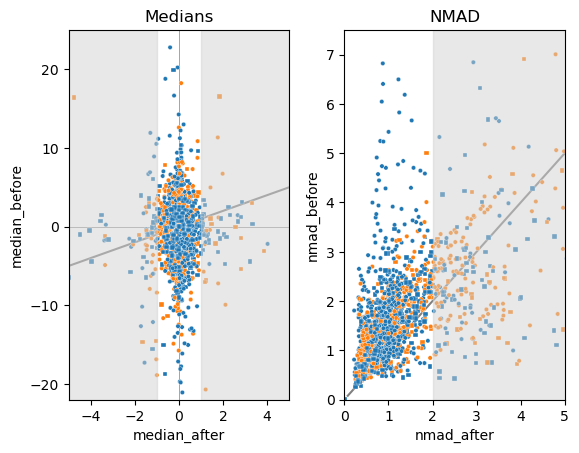

In [104]:
fig, axs = plt.subplots(ncols=2)

# MEDIAN
sns.scatterplot(data=coreg_meta,
                x='median_after',
                y='median_before',
                hue='lake_land',
                style='where',
                s=10,
                markers=['o','s'],
                ax=axs[0],
                legend=False)

axs[0].set(xlim=(-5, 5),
       ylim=(-22, 25)
)
axs[0].axhline(0, c='gray', zorder=0, lw=0.5)
axs[0].axvline(0, c='gray', zorder=0, lw=0.5)
plot_xeqy(axs[0])

axs[0].fill_between([-5, -1], -22, 25, color='lightgray', alpha=0.5)
axs[0].fill_between([1, 5], -22, 25, color='lightgray', alpha=0.5)

axs[0].set_title('Medians')

## NMAD
sns.scatterplot(data=coreg_meta,
                x='nmad_after',
                y='nmad_before',
                hue='lake_land',
                style='where',
                s=10,
                markers=['o','s'],
                ax=axs[1],
                legend=False)

axs[1].set(xlim=(0, 5),
           ylim=(0, 7.5)
)
plot_xeqy(axs[1])
axs[1].fill_between([2, 7.5], 0, 7.5, color='lightgray', alpha=0.5)
axs[1].set_title('NMAD')

plt.subplots_adjust(wspace=0.25)

### results

Buffered each centreline by 200 m and extracted rates of SEC for all gridsquares in buffered region along with the _median_ elevation from the stack of coregistered DEMs.

Plot of elevation against rate of SEC by Greenland/Iceland and lake/land.

In [106]:
sample_files = glob('../data/id*/sec_sample.parquet')
sample_files.remove('../data/id32_1327449x_-2520905y/sec_sample.parquet')  # removing dodgy 32!
# read in all sample files
samples = pd.concat(
    [pd.read_parquet(sf) for sf in sample_files]
)

print(f'there are {len(samples)} sample points in total\nand by where/type the breakdown is:')
print(samples.groupby(['where','lake_land'])['z_median'].count().to_markdown())

36
35
there are 368493 sample points in total
and by where/type the breakdown is:
|                       |   z_median |
|:----------------------|-----------:|
| ('greenland', 'lake') |     127960 |
| ('greenland', 'land') |     131159 |
| ('iceland', 'lake')   |      85808 |
| ('iceland', 'land')   |      23566 |


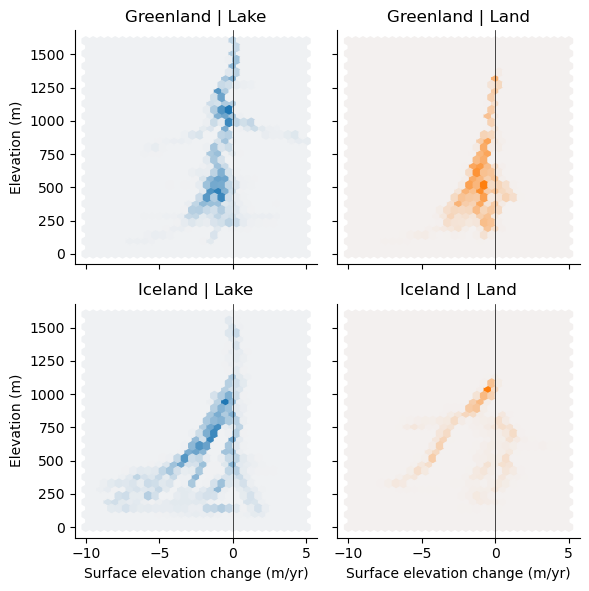

In [107]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=30, cmap=cmap, **kwargs)
    

fg = sns.FacetGrid(samples,
                    row='where',
                    col='lake_land',
                    hue='lake_land',
                    hue_order=['lake', 'land'],
                    row_order=['greenland', 'iceland'],
                    col_order=['lake', 'land'],
)
fg.map(hexbin, "slope", "z_median", extent=[-10,5,0,1600])

for ax in fg.axes.flat:
    t = ax.get_title()
    t = t.replace('where = ', "").replace('lake_land = ', "")
    ax.set_title(t.title())
    ax.axvline(0, c='k', lw=0.5)

fg.set(xlabel='Surface elevation change (m/yr)',
       ylabel='Elevation (m)')

In [115]:
samples['z_bins'] = pd.cut(samples['z_median'], np.arange(-50,2000,20))
samples['mid_bin'] = samples['z_bins'].apply(lambda x: int(x.mid))

lower = lambda x: np.quantile(x, 0.25)
upper = lambda x: np.quantile(x, 0.75)

slope_by_z = samples.groupby(['where', 'lake_land', 'mid_bin'],
                             observed=True)['slope'].agg([lower,
                                                          upper,
                                                          'median']).reset_index()
lake_land_df = pd.merge(
    slope_by_z.loc[slope_by_z['lake_land']=='land'].rename(columns={'<lambda_0>':'land_lower',
                                                                    '<lambda_1>':'land_upper',
                                                                    'median': 'land_median'}),
    slope_by_z.loc[slope_by_z['lake_land']=='lake'].rename(columns={'<lambda_0>':'lake_lower',
                                                                    '<lambda_1>':'lake_upper',
                                                                    'median': 'lake_median'}),
    left_on=['where', 'mid_bin'],
    right_on=['where', 'mid_bin']
    )

## nonsense for errorbars
lake_land_df['land_low_err'] = lake_land_df['land_median'] - lake_land_df['land_lower']
lake_land_df['land_up_err'] = lake_land_df['land_upper'] - lake_land_df['land_median']


lake_land_df['lake_low_err'] = lake_land_df['lake_median'] - lake_land_df['lake_lower']
lake_land_df['lake_up_err'] = lake_land_df['lake_upper'] - lake_land_df['lake_median']


Text(0, 0.5, 'Elevation (m)')

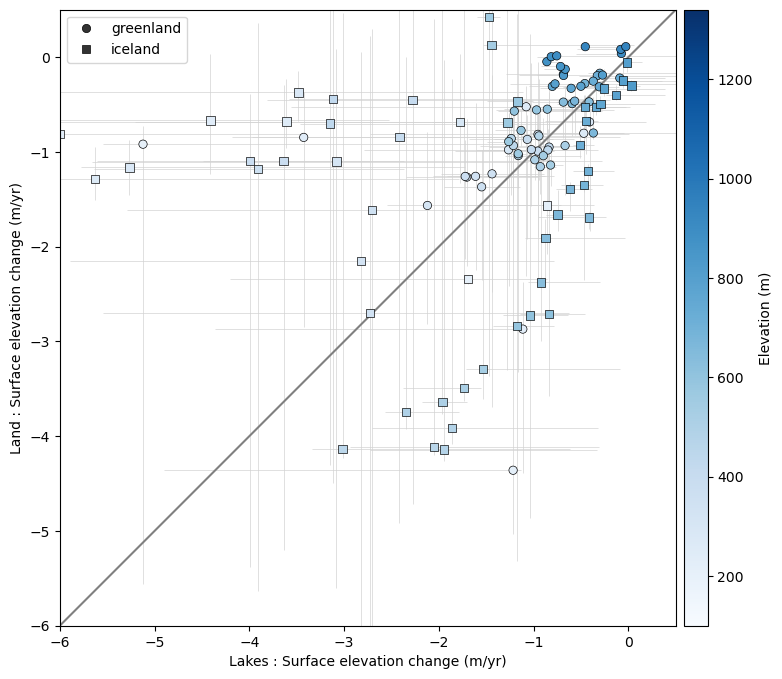

In [116]:
fig, ax = plt.subplots(figsize=[8,8])
sns.scatterplot(data=lake_land_df,
                x='lake_median',
                y='land_median',
                style='where',
                markers=['o','s'],
                hue='mid_bin',
                palette='Blues',
                ec='k',
                ax=ax,
                legend='brief'
                )

# quick sort of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])

ax.errorbar(x='lake_median',
            y='land_median',
            yerr=np.c_[lake_land_df['land_low_err'].values,
                       lake_land_df['land_up_err'].values].T,
            xerr=np.c_[lake_land_df['lake_low_err'].values,
                       lake_land_df['lake_up_err'].values].T,
            data=lake_land_df,
            fmt='none',
            ecolor='lightgray',
            elinewidth=0.5,
            zorder=0)

# limits and aspect ratio and x=y line
ax.set(xlim=(-6, 0.5),
       ylim=(-6, 0.5),
       xlabel='Lakes : Surface elevation change (m/yr)',
       ylabel='Land : Surface elevation change (m/yr)')
ax.set_aspect('equal')
plot_xeqy(ax)

# axes labels
ax,

########## elevation colorbar
norm = plt.Normalize(*lake_land_df['mid_bin'].agg(['min', 'max']))
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.01,
                    pos.y0,
                    0.03,
                    pos.height])

cb = plt.colorbar(sm, cax=cax)
cax.set_ylabel('Elevation (m)')

Text(0.5, 0, '<--- more thinning at lake <---| lake SEC - land SEC |---> more thinning at land --->')

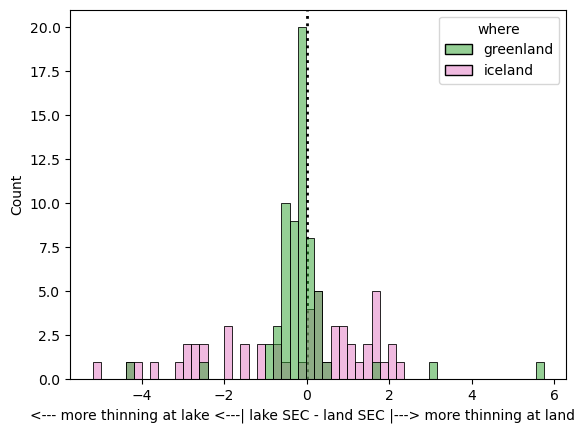

In [145]:
lake_land_df['diff_lake_sub_land'] = lake_land_df['lake_median'] - lake_land_df['land_median']

ax = sns.histplot(data=lake_land_df,
                 x='diff_lake_sub_land',
                 hue='where',
                 palette=['tab:green', 'tab:pink'],
                 binwidth=0.2
                 )

ax.axvline(0, c='k', zorder=0, lw=2, ls=':')

ax.set_xlabel('<--- more thinning at lake <---| lake SEC - land SEC |---> more thinning at land --->')